In [1]:
pip install yfinance --upgrade --no-cache-dir


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Imports

In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow import keras
from tensorflow.keras import layers

2024-06-03 21:30:30.391848: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-03 21:30:30.392386: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-03 21:30:30.395600: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-03 21:30:30.428455: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 21:30:31.085976: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

## Definindo Dataset

In [3]:
ticker = 'AAPL' # apple
data = yf.download(ticker, start='2020-01-01', end='2023-01-01')
data = data['Close']
data.head()

[*********************100%%**********************]  1 of 1 completed


Date
2020-01-02    75.087502
2020-01-03    74.357498
2020-01-06    74.949997
2020-01-07    74.597504
2020-01-08    75.797501
Name: Close, dtype: float64

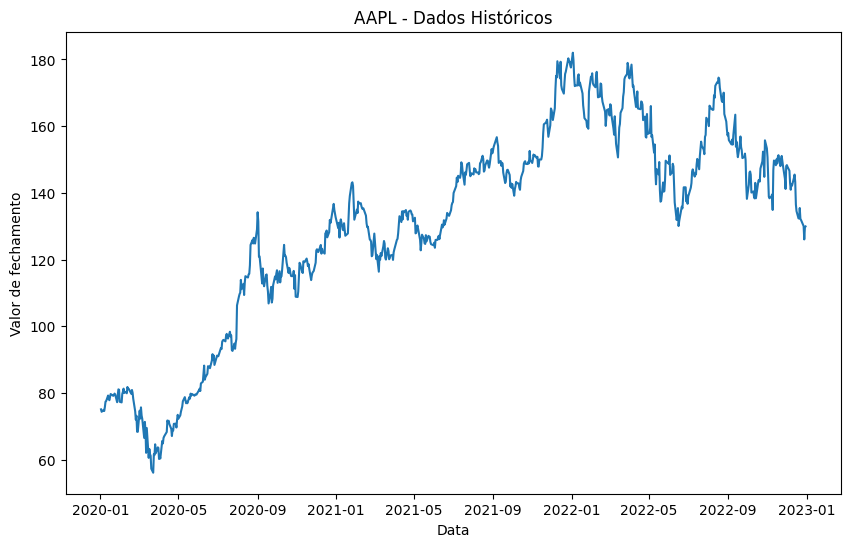

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(data)
plt.title(f'{ticker} - Dados Históricos')
plt.xlabel('Data')
plt.ylabel('Valor de fechamento')
plt.show()

## Naive Bayes 

In [5]:
def naive_forecast(data):
    forecast = data.shift(1)
    rmse = np.sqrt(mean_squared_error(data[1:], forecast[1:]))
    return forecast, rmse

Naive RMSE: 2.7924720976815447


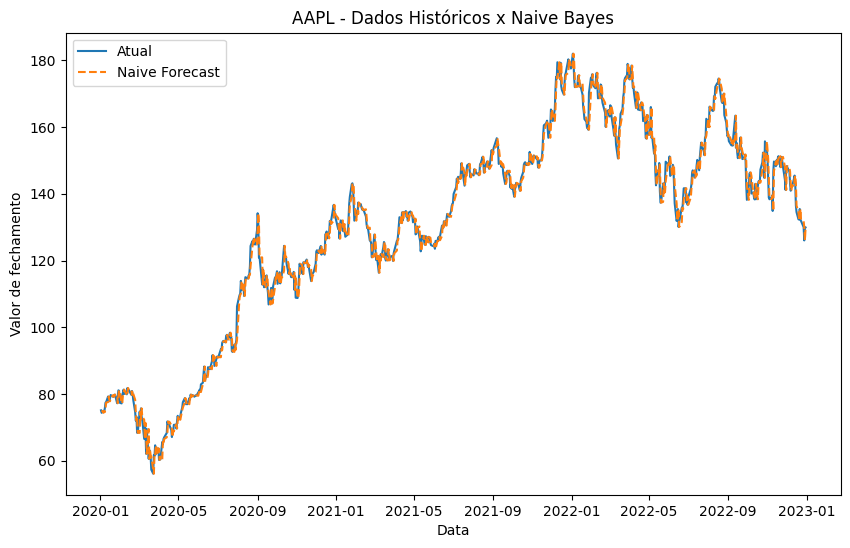

In [6]:
forecast, rmse = naive_forecast(data)
print(f'Naive RMSE: {rmse}')

plt.figure(figsize=(10, 6))
plt.plot(data, label='Atual')
plt.plot(forecast, label='Naive Forecast', linestyle='--')
plt.title(f'{ticker} - Dados Históricos x Naive Bayes')
plt.xlabel('Data')
plt.ylabel('Valor de fechamento')
plt.legend()
plt.show()

## Dense

In [7]:
sequence_length = 10

train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)
train_data, val_data = train_test_split(train_data, test_size=0.2, shuffle=False)

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
val_scaled = scaler.transform(val_data.values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_scaled, sequence_length)
X_val, y_val = create_dataset(val_scaled, sequence_length)
X_test, y_test = create_dataset(test_scaled, sequence_length)

# arquitetura da rede
inputs = keras.Input(shape=(sequence_length, 1))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

model = keras.models.load_model("best_model.keras")
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f" RMSE: {rmse:.2f}")

Epoch 1/10


2024-06-03 21:30:32.945878: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-03 21:30:32.946250: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7035 - mae: 0.7567 - val_loss: 0.8773 - val_mae: 0.9312
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2382 - mae: 0.4299 - val_loss: 0.2966 - val_mae: 0.5383
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0639 - mae: 0.2154 - val_loss: 0.0607 - val_mae: 0.2356
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118 - mae: 0.0917 - val_loss: 0.0105 - val_mae: 0.0846
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - mae: 0.0521 - val_loss: 0.0054 - val_mae: 0.0572
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - mae: 0.0453 - val_loss: 0.0045 - val_mae: 0.0519
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - mae: 0.0374 - val_loss: 0.0045 - val_mae: 0.0522
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - mae: 0.0318 - val_loss: 0.0036 - val_mae: 0.0512
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - mae: 0.0297 - va

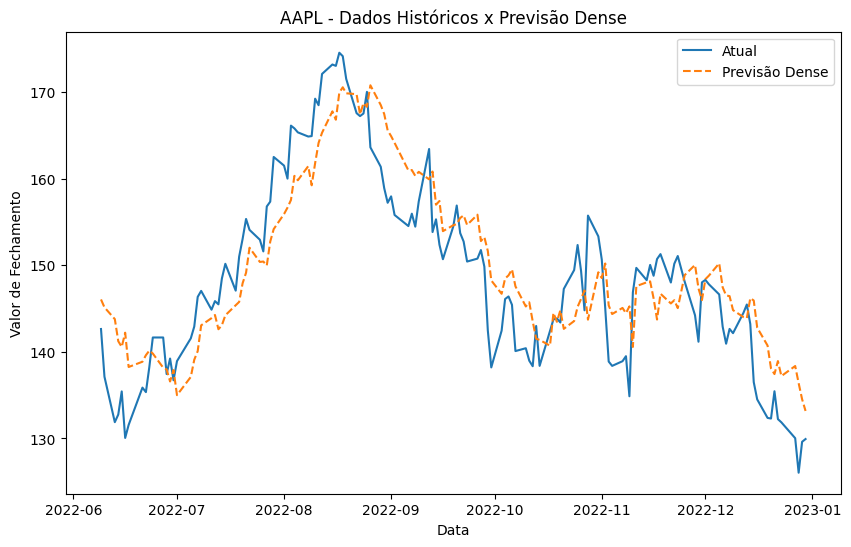

In [8]:
y_pred_descaled = scaler.inverse_transform(y_pred)

plt.figure(figsize=(10, 6))
plt.plot(test_data.index[sequence_length:], test_data.iloc[sequence_length:], label='Atual')
plt.plot(test_data.index[sequence_length:], y_pred_descaled, label='Previsão Dense', linestyle='--')
plt.title(f'{ticker} - Dados Históricos x Previsão Dense')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.show()

## LSTM